In [2]:
########################################## BRAIN TUMOR DETECTION WITH MASK RCNN
import json
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from PIL import Image
#from torchvision import transforms as T
from scipy.ndimage import binary_erosion


import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def bw_on_image(im, bw, color):
    for i in range(0, im.shape[2]):
        t = im[:, :, i]
        t[bw] = color[i]
        im[:, :, i] = t
    #return img
    
def find_edge(bw, strel=5):
    return np.bitwise_xor(bw, binary_erosion(bw, structure=np.ones((strel, strel))).astype(bw.dtype))     

def getMaskfromPoly(imgsize,ypoints,xpoints):
    
    out=np.zeros((imgsize[0],imgsize[1]))
    coords=lst=[(i,j) for i,j in zip(xpoints,ypoints) ]
    poly=Polygon(coords)
     
    for i in range(imgsize[0]):
        for j in range(imgsize[1]):
            p1=Point(i,j)
            if poly.contains(p1):
                out[i,j]=1
    return out
        

class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root,mode))))
        #print(self.imgs)
        f=open(root+'annotations_'+mode.lower()+'.json')
        self.annotations=json.load(f)
        self.mode=mode

        #xpoints=annotations['y0.jpg19127']['regions'][0]['shape_attributes']['all_points_x']
        #self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
    
    def getMaskfromPoly(self,imgname,imgsize):
        #print(imgname)

        dic=self.annotations[imgname+str(os.path.getsize(self.root+self.mode+'/'+imgname))]['regions'][0]['shape_attributes']
            #try:
        if  dic['name']=='polygon':
            xpoints=dic['all_points_x']
            ypoints=dic['all_points_y']

        elif dic['name']=='ellipse':
            u=dic['cx']       #x-position of the center
            v=dic['cy']      #y-position of the center
            a=dic['rx']       #radius on the x-axis
            b=dic['ry']      #radius on the y-axis
            t_rot=dic['theta'] #rotation angle
            t = np.linspace(0, 2*pi, 100)
            Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
                     #u,v removed to keep the same center location
            R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
                     #2-D rotation matrix
            Ell_rot = np.zeros((2,Ell.shape[1]))
            for i in range(Ell.shape[1]):
                Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
                xpoints=u+Ell_rot[0,:]
                ypoints=v+Ell_rot[1,:]
                
        elif dic['name']=='circle':
            theta = np.linspace( 0 , 2 * np.pi , 150 )
            radius = dic['r']
            xpoints = dic['cx']+radius * np.cos( theta )
            ypoints = dic['cy']+radius * np.sin( theta ) 
            
        out=np.zeros((imgsize[0],imgsize[1]))
        coords=lst=[(i,j) for i,j in zip(ypoints,xpoints) ]
        poly=Polygon(coords)

        for i in range(imgsize[0]):
            for j in range(imgsize[1]):
                p1=Point(i,j)
                if poly.contains(p1):
                    out[i,j]=1

        return out

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.mode+'/', self.imgs[idx])
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        #mask = Image.open(mask_path)
        mask=self.getMaskfromPoly(self.imgs[idx],np.array(img).shape)
        img=img.resize((280,350),Image.NEAREST)
        mask=Image.fromarray(np.uint8(mask)).convert('RGB')
        mask=mask.resize((280,350),Image.NEAREST)
        mask = np.array(mask)
        mask=mask[:,:,0]
        
        #imt=np.array(img.copy())
        #self.bw_on_image(imt,(mask>0),[255,0,255])
        #plt.imshow(img)
        #plt.show()
        #plt.imshow(mask)
        #plt.show()
        
        # convert the PIL Image into a numpy array
        
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            #print(target)
            img, target = self.transforms(img, target)
            #print(target)
            #img=self.transforms(img)

        return img, target
    
    def bw_on_image(self,im, bw, color):
        for i in range(0, im.shape[2]):
            t = im[:, :, i]
            t[bw] = color[i]
            im[:, :, i] = t

    def __len__(self):
        return len(self.imgs)   
    

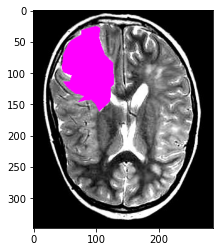

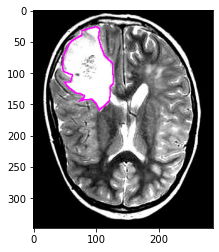

In [3]:
# choeck the data and annotations
import shutil
import math
from math import pi, cos, sin

path='C:/matcode/data/brainTumor/Br35H-Mask-RCNN/'
f=open(path+'annotations_train.json')
annotations=json.load(f)
#print(os.listdir(path+'TRAIN/'))

for imgname in os.listdir(path+'TRAIN/'):
    im = plt.imread(path+'TRAIN/'+imgname)
    dic=annotations[imgname+str(os.path.getsize(path+'TRAIN/'+imgname))]['regions'][0]['shape_attributes']
    #try:
    if  dic['name']=='polygon':
        xpoints=dic['all_points_x']
        ypoints=dic['all_points_y']
              
    elif dic['name']=='ellipse':

        u=dic['cx']       #x-position of the center
        v=dic['cy']      #y-position of the center
        a=dic['rx']       #radius on the x-axis
        b=dic['ry']      #radius on the y-axis
        t_rot=dic['theta'] #rotation angle

        t = np.linspace(0, 2*pi, 200)
        Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
             #u,v removed to keep the same center location
        R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
             #2-D rotation matrix

        Ell_rot = np.zeros((2,Ell.shape[1]))
        for i in range(Ell.shape[1]):
            Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
        xpoints=u+Ell_rot[0,:]
        ypoints=v+Ell_rot[1,:]
        #plt.imshow(im)
        #plt.plot( u+Ell[0,:] , v+Ell[1,:] )     #initial ellipse
        #plt.plot( u+Ell_rot[0,:] , v+Ell_rot[1,:],'darkorange' )    #rotated ellipse
        #plt.show()
    elif dic['name']=='circle':
        plt.imshow(im)
        theta = np.linspace( 0 , 2 * np.pi , 200 )
        radius = dic['r']
        xpoints = dic['cx']+radius * np.cos( theta )
        ypoints = dic['cy']+radius * np.sin( theta )
        #plt.plot(a,b)
        #plt.show()

        
    mask=getMaskfromPoly(im.shape,xpoints,ypoints)
    imt=im.copy()
    bw_on_image(imt,(mask>0),[255,0,255])
    plt.imshow(imt)
    plt.show()
    
    imt2=im.copy()
    bw_on_image(imt2,(find_edge( mask>0)),[255,0,255])
    plt.imshow(imt2)
    plt.show()
    break
    
        

In [4]:
###### Build the pytorch custome dataset and load mask rcnn model
import torchvision
batch_size=4

ds_tr=BrainTumorDataset(path,'TRAIN',get_transform(train=True))
train_dataloader = DataLoader(ds_tr, batch_size=batch_size)

ds_test=BrainTumorDataset(path,'TEST',get_transform(train=False))
test_dataloader = DataLoader(ds_test, batch_size=batch_size)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
    



Using cuda device


In [4]:
testbach,testmasks=next(iter(test_dataloader))
print(testbach.shape)
timg=testbach[0,:,:,:].numpy()
plt.imshow(np.moveaxis(timg,0,-1))

NameError: name 'test_dataloader' is not defined

In [7]:
import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset


def train_one_epoch(
    model,
    optimizer,
    data_loader,
    device,
    epoch,
    print_freq,
     scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(
        window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(
        data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        targets2 = [{}] * len(images)
        for j in range(len(targets2)):
            for j2, v2 in targets.items():
                targets2[j][j2] = v2[j].to(device)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets2)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    #torch.set_num_threads(1)
    #cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        targets2 = [{}] * len(images)
        for j in range(len(targets2)):
            for j2, v2 in targets.items():
                targets2[j][j2] = v2[j].to(device)

        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        #outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets2, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [8]:
#from engine import train_one_epoch, evaluate
import utils
#autopep8 --aggressive --select=E1,W1 engine.py #fixes indent inconsistancy
num_epochs = 50
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                             momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

for epoch in range(num_epochs):
     # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
        # update the learning rate
    lr_scheduler.step()
        # evaluate on the test dataset
    evaluate(model, test_dataloader, device=device)


#for  i,(imgs,masks) in enumerate(train_dataloader):
#    imgs = list(image for image in imgs)
#    masks2 = [{}]*len(imgs)
#    for j in range(len(masks2)):
#        for j2, v2 in masks.items():
#            masks2[j][j2] = v2[j]
    
#    output=model(imgs,masks2)
#    print(output)
#    break


Epoch: [0]  [  0/125]  eta: 0:35:45  lr: 0.000045  loss: 1.0753 (1.0753)  loss_classifier: 0.2096 (0.2096)  loss_box_reg: 0.0506 (0.0506)  loss_mask: 0.7691 (0.7691)  loss_objectness: 0.0209 (0.0209)  loss_rpn_box_reg: 0.0250 (0.0250)  time: 17.1679  data: 16.3195  max mem: 4192
Epoch: [0]  [ 10/125]  eta: 0:14:11  lr: 0.000448  loss: 0.7913 (0.8210)  loss_classifier: 0.1138 (0.1233)  loss_box_reg: 0.0469 (0.0476)  loss_mask: 0.6074 (0.6056)  loss_objectness: 0.0233 (0.0332)  loss_rpn_box_reg: 0.0098 (0.0113)  time: 7.4081  data: 6.5822  max mem: 4473
Epoch: [0]  [ 20/125]  eta: 0:13:20  lr: 0.000851  loss: 0.7615 (0.8033)  loss_classifier: 0.1124 (0.1165)  loss_box_reg: 0.0529 (0.0576)  loss_mask: 0.5705 (0.5881)  loss_objectness: 0.0233 (0.0316)  loss_rpn_box_reg: 0.0074 (0.0095)  time: 7.1421  data: 6.3296  max mem: 4473
Epoch: [0]  [ 30/125]  eta: 0:12:50  lr: 0.001254  loss: 0.7203 (0.7666)  loss_classifier: 0.0917 (0.1035)  loss_box_reg: 0.0578 (0.0593)  loss_mask: 0.5108 (0.5660

Epoch: [1]  [ 70/125]  eta: 0:07:44  lr: 0.005000  loss: 0.6228 (0.6605)  loss_classifier: 0.0925 (0.0949)  loss_box_reg: 0.0735 (0.0790)  loss_mask: 0.4380 (0.4620)  loss_objectness: 0.0184 (0.0212)  loss_rpn_box_reg: 0.0021 (0.0034)  time: 9.1357  data: 8.3477  max mem: 4473
Epoch: [1]  [ 80/125]  eta: 0:06:08  lr: 0.005000  loss: 0.5975 (0.6532)  loss_classifier: 0.0893 (0.0947)  loss_box_reg: 0.0735 (0.0784)  loss_mask: 0.4201 (0.4557)  loss_objectness: 0.0174 (0.0209)  loss_rpn_box_reg: 0.0029 (0.0034)  time: 8.2331  data: 7.4442  max mem: 4473
Epoch: [1]  [ 90/125]  eta: 0:04:43  lr: 0.005000  loss: 0.6352 (0.6547)  loss_classifier: 0.0907 (0.0952)  loss_box_reg: 0.0745 (0.0790)  loss_mask: 0.4316 (0.4564)  loss_objectness: 0.0171 (0.0207)  loss_rpn_box_reg: 0.0029 (0.0035)  time: 6.8955  data: 6.1032  max mem: 4473
Epoch: [1]  [100/125]  eta: 0:03:19  lr: 0.005000  loss: 0.6434 (0.6511)  loss_classifier: 0.0929 (0.0949)  loss_box_reg: 0.0745 (0.0782)  loss_mask: 0.4520 (0.4523) 

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:09  model_time: 0.4530 (0.4530)  evaluator_time: 0.0156 (0.0156)  time: 5.1912  data: 4.7069  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4065 (0.4163)  evaluator_time: 0.0000 (0.0056)  time: 7.9991  data: 7.5772  max mem: 4473
Test: Total time: 0:03:17 (7.8900 s / it)
Averaged stats: model_time: 0.4065 (0.4163)  evaluator_time: 0.0000 (0.0056)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [4]  [  0/125]  eta: 0:33:25  lr: 0.000500  loss: 0.6363 (0.6363)  loss_classifier: 0.1018 (0.1018)  loss_box_reg: 0.1033 (0.1033)  loss_mask: 0.4032 (0.4032)  loss_objectness: 0.0131 (0.0131)  loss_rpn_box_reg: 0.0149 (0.0149)  time: 16.0419  data: 15.2452  max mem: 4473
Epoch: [4]  [ 10/125]  eta: 0:13:48  lr: 0.000500  loss: 0.5832 (0.5778)  loss_classifier: 0.0871 (0.0874)  loss_box_reg: 0.0699 (0.0728)  loss_mask: 0.4032 (0.3971)  loss_objectness: 0.0116 (0.0165)  loss_rpn_box_reg: 0.0038 (0.0039)  time: 7.2009  data: 6.4097  max mem: 4473
Epoch: [4]  [ 20/125]  eta: 0:13:19  lr: 0.000500  loss: 0.5832 (0.5888)  loss_classifier: 0.0839 (0.0870)  loss_box_reg: 0.0710 (0.0749)  loss_mask: 0.4071 (0.4100)  loss_objectness: 0.0112 (0.0136)  loss_rpn_box_reg: 0.0017 (0.0032)  time: 7.1921  data: 6.3808  max mem: 4473
Epoch: [4]  [ 30/125]  eta: 0:12:52  lr: 0.000500  loss: 0.5993 (0.5914)  loss_classifier: 0.0847 (0.0862)  loss_box_reg: 0.0717 (0.0731)  loss_mask: 0.4121 (0.4154

Epoch: [5]  [ 70/125]  eta: 0:07:35  lr: 0.000500  loss: 0.5560 (0.5799)  loss_classifier: 0.0890 (0.0880)  loss_box_reg: 0.0672 (0.0710)  loss_mask: 0.3758 (0.4038)  loss_objectness: 0.0108 (0.0146)  loss_rpn_box_reg: 0.0021 (0.0026)  time: 9.1467  data: 8.3529  max mem: 4473
Epoch: [5]  [ 80/125]  eta: 0:06:02  lr: 0.000500  loss: 0.5590 (0.5797)  loss_classifier: 0.1003 (0.0897)  loss_box_reg: 0.0756 (0.0721)  loss_mask: 0.3746 (0.4009)  loss_objectness: 0.0117 (0.0143)  loss_rpn_box_reg: 0.0021 (0.0027)  time: 8.2722  data: 7.4704  max mem: 4473
Epoch: [5]  [ 90/125]  eta: 0:04:39  lr: 0.000500  loss: 0.5835 (0.5803)  loss_classifier: 0.1003 (0.0900)  loss_box_reg: 0.0752 (0.0723)  loss_mask: 0.3804 (0.4008)  loss_objectness: 0.0119 (0.0144)  loss_rpn_box_reg: 0.0022 (0.0027)  time: 6.9251  data: 6.1250  max mem: 4473
Epoch: [5]  [100/125]  eta: 0:03:17  lr: 0.000500  loss: 0.5757 (0.5772)  loss_classifier: 0.0849 (0.0900)  loss_box_reg: 0.0738 (0.0713)  loss_mask: 0.3882 (0.3975) 

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:03  model_time: 0.4374 (0.4374)  evaluator_time: 0.0156 (0.0156)  time: 4.9261  data: 4.4575  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4374 (0.4382)  evaluator_time: 0.0000 (0.0056)  time: 8.0491  data: 7.6053  max mem: 4473
Test: Total time: 0:03:15 (7.8155 s / it)
Averaged stats: model_time: 0.4374 (0.4382)  evaluator_time: 0.0000 (0.0056)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.759
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.571
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [8]  [  0/125]  eta: 0:33:34  lr: 0.000050  loss: 0.6456 (0.6456)  loss_classifier: 0.0816 (0.0816)  loss_box_reg: 0.0827 (0.0827)  loss_mask: 0.4467 (0.4467)  loss_objectness: 0.0185 (0.0185)  loss_rpn_box_reg: 0.0161 (0.0161)  time: 16.1156  data: 15.3346  max mem: 4473
Epoch: [8]  [ 10/125]  eta: 0:13:43  lr: 0.000050  loss: 0.5580 (0.5546)  loss_classifier: 0.0929 (0.0832)  loss_box_reg: 0.0730 (0.0694)  loss_mask: 0.3745 (0.3829)  loss_objectness: 0.0106 (0.0154)  loss_rpn_box_reg: 0.0032 (0.0037)  time: 7.1622  data: 6.3723  max mem: 4473
Epoch: [8]  [ 20/125]  eta: 0:13:11  lr: 0.000050  loss: 0.5569 (0.5703)  loss_classifier: 0.0852 (0.0849)  loss_box_reg: 0.0659 (0.0721)  loss_mask: 0.3856 (0.3966)  loss_objectness: 0.0108 (0.0138)  loss_rpn_box_reg: 0.0017 (0.0028)  time: 7.1066  data: 6.3122  max mem: 4473
Epoch: [8]  [ 30/125]  eta: 0:12:34  lr: 0.000050  loss: 0.5690 (0.5754)  loss_classifier: 0.0809 (0.0834)  loss_box_reg: 0.0659 (0.0712)  loss_mask: 0.4010 (0.4046

Epoch: [9]  [ 70/125]  eta: 0:07:32  lr: 0.000005  loss: 0.5412 (0.5743)  loss_classifier: 0.0882 (0.0888)  loss_box_reg: 0.0686 (0.0706)  loss_mask: 0.3724 (0.3968)  loss_objectness: 0.0124 (0.0155)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 8.9874  data: 8.1948  max mem: 4473
Epoch: [9]  [ 80/125]  eta: 0:05:59  lr: 0.000005  loss: 0.5781 (0.5732)  loss_classifier: 0.1004 (0.0900)  loss_box_reg: 0.0756 (0.0716)  loss_mask: 0.3764 (0.3938)  loss_objectness: 0.0122 (0.0151)  loss_rpn_box_reg: 0.0023 (0.0027)  time: 8.1213  data: 7.3274  max mem: 4473
Epoch: [9]  [ 90/125]  eta: 0:04:36  lr: 0.000005  loss: 0.5689 (0.5708)  loss_classifier: 0.0968 (0.0896)  loss_box_reg: 0.0756 (0.0713)  loss_mask: 0.3759 (0.3923)  loss_objectness: 0.0112 (0.0149)  loss_rpn_box_reg: 0.0023 (0.0027)  time: 6.7792  data: 5.9854  max mem: 4473
Epoch: [9]  [100/125]  eta: 0:03:15  lr: 0.000005  loss: 0.5655 (0.5717)  loss_classifier: 0.0843 (0.0906)  loss_box_reg: 0.0646 (0.0707)  loss_mask: 0.3803 (0.3915) 

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:11  model_time: 0.4530 (0.4530)  evaluator_time: 0.0156 (0.0156)  time: 5.2553  data: 4.7711  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4374 (0.4369)  evaluator_time: 0.0156 (0.0100)  time: 7.9762  data: 7.5301  max mem: 4473
Test: Total time: 0:03:15 (7.8115 s / it)
Averaged stats: model_time: 0.4374 (0.4369)  evaluator_time: 0.0156 (0.0100)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [12]  [  0/125]  eta: 0:32:59  lr: 0.000001  loss: 0.6384 (0.6384)  loss_classifier: 0.0896 (0.0896)  loss_box_reg: 0.0945 (0.0945)  loss_mask: 0.4275 (0.4275)  loss_objectness: 0.0118 (0.0118)  loss_rpn_box_reg: 0.0151 (0.0151)  time: 15.8337  data: 15.0370  max mem: 4473
Epoch: [12]  [ 10/125]  eta: 0:13:34  lr: 0.000001  loss: 0.5548 (0.5514)  loss_classifier: 0.0855 (0.0828)  loss_box_reg: 0.0670 (0.0721)  loss_mask: 0.3815 (0.3778)  loss_objectness: 0.0096 (0.0151)  loss_rpn_box_reg: 0.0030 (0.0036)  time: 7.0839  data: 6.2941  max mem: 4473
Epoch: [12]  [ 20/125]  eta: 0:12:55  lr: 0.000001  loss: 0.5513 (0.5590)  loss_classifier: 0.0840 (0.0837)  loss_box_reg: 0.0657 (0.0708)  loss_mask: 0.3811 (0.3887)  loss_objectness: 0.0098 (0.0131)  loss_rpn_box_reg: 0.0015 (0.0027)  time: 6.9601  data: 6.1702  max mem: 4473
Epoch: [12]  [ 30/125]  eta: 0:12:30  lr: 0.000001  loss: 0.5557 (0.5627)  loss_classifier: 0.0816 (0.0827)  loss_box_reg: 0.0671 (0.0696)  loss_mask: 0.3967 (0.

Epoch: [13]  [ 70/125]  eta: 0:07:30  lr: 0.000001  loss: 0.5504 (0.5770)  loss_classifier: 0.0874 (0.0882)  loss_box_reg: 0.0666 (0.0703)  loss_mask: 0.3772 (0.4010)  loss_objectness: 0.0120 (0.0148)  loss_rpn_box_reg: 0.0019 (0.0027)  time: 8.9355  data: 8.1446  max mem: 4473
Epoch: [13]  [ 80/125]  eta: 0:05:58  lr: 0.000001  loss: 0.5700 (0.5767)  loss_classifier: 0.0966 (0.0897)  loss_box_reg: 0.0718 (0.0713)  loss_mask: 0.3896 (0.3985)  loss_objectness: 0.0120 (0.0145)  loss_rpn_box_reg: 0.0020 (0.0027)  time: 8.1158  data: 7.3209  max mem: 4473
Epoch: [13]  [ 90/125]  eta: 0:04:36  lr: 0.000001  loss: 0.5519 (0.5752)  loss_classifier: 0.0936 (0.0896)  loss_box_reg: 0.0709 (0.0710)  loss_mask: 0.3738 (0.3974)  loss_objectness: 0.0120 (0.0145)  loss_rpn_box_reg: 0.0022 (0.0027)  time: 6.8019  data: 6.0075  max mem: 4473
Epoch: [13]  [100/125]  eta: 0:03:14  lr: 0.000001  loss: 0.5722 (0.5739)  loss_classifier: 0.0834 (0.0898)  loss_box_reg: 0.0590 (0.0702)  loss_mask: 0.3790 (0.39

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:05  model_time: 0.4378 (0.4378)  evaluator_time: 0.0156 (0.0156)  time: 5.0364  data: 4.5674  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4377 (0.4351)  evaluator_time: 0.0156 (0.0088)  time: 7.9735  data: 7.5297  max mem: 4473
Test: Total time: 0:03:13 (7.7524 s / it)
Averaged stats: model_time: 0.4377 (0.4351)  evaluator_time: 0.0156 (0.0088)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [16]  [  0/125]  eta: 0:32:56  lr: 0.000000  loss: 0.6666 (0.6666)  loss_classifier: 0.0862 (0.0862)  loss_box_reg: 0.0847 (0.0847)  loss_mask: 0.4662 (0.4662)  loss_objectness: 0.0133 (0.0133)  loss_rpn_box_reg: 0.0163 (0.0163)  time: 15.8113  data: 15.0299  max mem: 4473
Epoch: [16]  [ 10/125]  eta: 0:13:47  lr: 0.000000  loss: 0.5423 (0.5611)  loss_classifier: 0.0869 (0.0825)  loss_box_reg: 0.0769 (0.0704)  loss_mask: 0.3831 (0.3904)  loss_objectness: 0.0125 (0.0141)  loss_rpn_box_reg: 0.0031 (0.0037)  time: 7.1935  data: 6.4037  max mem: 4473
Epoch: [16]  [ 20/125]  eta: 0:13:03  lr: 0.000000  loss: 0.5540 (0.5714)  loss_classifier: 0.0848 (0.0826)  loss_box_reg: 0.0711 (0.0716)  loss_mask: 0.3898 (0.4020)  loss_objectness: 0.0090 (0.0123)  loss_rpn_box_reg: 0.0018 (0.0028)  time: 7.0463  data: 6.2509  max mem: 4473
Epoch: [16]  [ 30/125]  eta: 0:12:36  lr: 0.000000  loss: 0.5596 (0.5729)  loss_classifier: 0.0772 (0.0814)  loss_box_reg: 0.0685 (0.0693)  loss_mask: 0.3992 (0.

Epoch: [17]  [ 70/125]  eta: 0:07:31  lr: 0.000000  loss: 0.5427 (0.5741)  loss_classifier: 0.0916 (0.0864)  loss_box_reg: 0.0638 (0.0689)  loss_mask: 0.3666 (0.4001)  loss_objectness: 0.0108 (0.0161)  loss_rpn_box_reg: 0.0021 (0.0026)  time: 9.0181  data: 8.2245  max mem: 4473
Epoch: [17]  [ 80/125]  eta: 0:05:58  lr: 0.000000  loss: 0.5631 (0.5730)  loss_classifier: 0.0949 (0.0877)  loss_box_reg: 0.0704 (0.0700)  loss_mask: 0.3714 (0.3969)  loss_objectness: 0.0130 (0.0159)  loss_rpn_box_reg: 0.0021 (0.0026)  time: 8.1086  data: 7.3165  max mem: 4473
Epoch: [17]  [ 90/125]  eta: 0:04:36  lr: 0.000000  loss: 0.5753 (0.5735)  loss_classifier: 0.0962 (0.0881)  loss_box_reg: 0.0736 (0.0702)  loss_mask: 0.3818 (0.3967)  loss_objectness: 0.0137 (0.0158)  loss_rpn_box_reg: 0.0021 (0.0027)  time: 6.8116  data: 6.0216  max mem: 4473
Epoch: [17]  [100/125]  eta: 0:03:14  lr: 0.000000  loss: 0.5753 (0.5698)  loss_classifier: 0.0913 (0.0881)  loss_box_reg: 0.0653 (0.0692)  loss_mask: 0.3732 (0.39

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:09  model_time: 0.4374 (0.4374)  evaluator_time: 0.0156 (0.0156)  time: 5.1758  data: 4.7045  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4374 (0.4357)  evaluator_time: 0.0000 (0.0050)  time: 7.9033  data: 7.4610  max mem: 4473
Test: Total time: 0:03:12 (7.7175 s / it)
Averaged stats: model_time: 0.4374 (0.4357)  evaluator_time: 0.0000 (0.0050)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [20]  [  0/125]  eta: 0:33:52  lr: 0.000000  loss: 0.6558 (0.6558)  loss_classifier: 0.1054 (0.1054)  loss_box_reg: 0.1023 (0.1023)  loss_mask: 0.4151 (0.4151)  loss_objectness: 0.0173 (0.0173)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 16.2565  data: 15.4595  max mem: 4473
Epoch: [20]  [ 10/125]  eta: 0:13:48  lr: 0.000000  loss: 0.5473 (0.5528)  loss_classifier: 0.0930 (0.0855)  loss_box_reg: 0.0743 (0.0710)  loss_mask: 0.3739 (0.3797)  loss_objectness: 0.0102 (0.0129)  loss_rpn_box_reg: 0.0030 (0.0037)  time: 7.2034  data: 6.4136  max mem: 4473
Epoch: [20]  [ 20/125]  eta: 0:13:08  lr: 0.000000  loss: 0.5519 (0.5656)  loss_classifier: 0.0891 (0.0857)  loss_box_reg: 0.0665 (0.0706)  loss_mask: 0.3898 (0.3949)  loss_objectness: 0.0088 (0.0115)  loss_rpn_box_reg: 0.0014 (0.0028)  time: 7.0673  data: 6.2744  max mem: 4473
Epoch: [20]  [ 30/125]  eta: 0:12:41  lr: 0.000000  loss: 0.5603 (0.5661)  loss_classifier: 0.0826 (0.0848)  loss_box_reg: 0.0689 (0.0698)  loss_mask: 0.4009 (0.

Epoch: [21]  [ 70/125]  eta: 0:07:29  lr: 0.000000  loss: 0.5358 (0.5718)  loss_classifier: 0.0848 (0.0860)  loss_box_reg: 0.0631 (0.0689)  loss_mask: 0.3714 (0.3982)  loss_objectness: 0.0108 (0.0161)  loss_rpn_box_reg: 0.0023 (0.0027)  time: 8.9494  data: 8.1616  max mem: 4473
Epoch: [21]  [ 80/125]  eta: 0:05:57  lr: 0.000000  loss: 0.5484 (0.5690)  loss_classifier: 0.0910 (0.0867)  loss_box_reg: 0.0725 (0.0695)  loss_mask: 0.3737 (0.3944)  loss_objectness: 0.0099 (0.0158)  loss_rpn_box_reg: 0.0021 (0.0027)  time: 8.0697  data: 7.2775  max mem: 4473
Epoch: [21]  [ 90/125]  eta: 0:04:35  lr: 0.000000  loss: 0.5594 (0.5705)  loss_classifier: 0.0883 (0.0869)  loss_box_reg: 0.0681 (0.0698)  loss_mask: 0.3898 (0.3953)  loss_objectness: 0.0111 (0.0157)  loss_rpn_box_reg: 0.0021 (0.0027)  time: 6.7943  data: 5.9966  max mem: 4473
Epoch: [21]  [100/125]  eta: 0:03:14  lr: 0.000000  loss: 0.5665 (0.5683)  loss_classifier: 0.0856 (0.0869)  loss_box_reg: 0.0606 (0.0688)  loss_mask: 0.4018 (0.39

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:05  model_time: 0.4378 (0.4378)  evaluator_time: 0.0000 (0.0000)  time: 5.0057  data: 4.5524  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4221 (0.4338)  evaluator_time: 0.0156 (0.0081)  time: 7.9639  data: 7.5209  max mem: 4473
Test: Total time: 0:03:13 (7.7544 s / it)
Averaged stats: model_time: 0.4221 (0.4338)  evaluator_time: 0.0156 (0.0081)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [24]  [  0/125]  eta: 0:33:32  lr: 0.000000  loss: 0.6879 (0.6879)  loss_classifier: 0.0975 (0.0975)  loss_box_reg: 0.0968 (0.0968)  loss_mask: 0.4643 (0.4643)  loss_objectness: 0.0132 (0.0132)  loss_rpn_box_reg: 0.0161 (0.0161)  time: 16.1034  data: 15.3219  max mem: 4473
Epoch: [24]  [ 10/125]  eta: 0:13:43  lr: 0.000000  loss: 0.5506 (0.5692)  loss_classifier: 0.0924 (0.0879)  loss_box_reg: 0.0678 (0.0727)  loss_mask: 0.3922 (0.3911)  loss_objectness: 0.0116 (0.0139)  loss_rpn_box_reg: 0.0030 (0.0036)  time: 7.1633  data: 6.3729  max mem: 4473
Epoch: [24]  [ 20/125]  eta: 0:13:00  lr: 0.000000  loss: 0.5680 (0.5729)  loss_classifier: 0.0894 (0.0870)  loss_box_reg: 0.0678 (0.0727)  loss_mask: 0.3859 (0.3977)  loss_objectness: 0.0101 (0.0127)  loss_rpn_box_reg: 0.0016 (0.0027)  time: 6.9986  data: 6.2064  max mem: 4473
Epoch: [24]  [ 30/125]  eta: 0:12:34  lr: 0.000000  loss: 0.5783 (0.5752)  loss_classifier: 0.0814 (0.0858)  loss_box_reg: 0.0687 (0.0710)  loss_mask: 0.3944 (0.

Epoch: [25]  [ 70/125]  eta: 0:07:32  lr: 0.000000  loss: 0.5522 (0.5755)  loss_classifier: 0.0878 (0.0865)  loss_box_reg: 0.0696 (0.0697)  loss_mask: 0.3710 (0.4007)  loss_objectness: 0.0139 (0.0160)  loss_rpn_box_reg: 0.0024 (0.0027)  time: 8.9883  data: 8.1956  max mem: 4473
Epoch: [25]  [ 80/125]  eta: 0:05:58  lr: 0.000000  loss: 0.5829 (0.5755)  loss_classifier: 0.0965 (0.0883)  loss_box_reg: 0.0719 (0.0709)  loss_mask: 0.3903 (0.3980)  loss_objectness: 0.0120 (0.0156)  loss_rpn_box_reg: 0.0024 (0.0027)  time: 8.0655  data: 7.2700  max mem: 4473
Epoch: [25]  [ 90/125]  eta: 0:04:37  lr: 0.000000  loss: 0.5875 (0.5764)  loss_classifier: 0.0955 (0.0886)  loss_box_reg: 0.0754 (0.0711)  loss_mask: 0.3790 (0.3984)  loss_objectness: 0.0109 (0.0155)  loss_rpn_box_reg: 0.0021 (0.0027)  time: 6.8607  data: 6.0645  max mem: 4473
Epoch: [25]  [100/125]  eta: 0:03:15  lr: 0.000000  loss: 0.5774 (0.5740)  loss_classifier: 0.0903 (0.0890)  loss_box_reg: 0.0601 (0.0703)  loss_mask: 0.3790 (0.39

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:06  model_time: 0.4534 (0.4534)  evaluator_time: 0.0000 (0.0000)  time: 5.0520  data: 4.5830  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4374 (0.4382)  evaluator_time: 0.0156 (0.0075)  time: 7.9728  data: 7.5252  max mem: 4473
Test: Total time: 0:03:14 (7.7645 s / it)
Averaged stats: model_time: 0.4374 (0.4382)  evaluator_time: 0.0156 (0.0075)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [28]  [  0/125]  eta: 0:33:24  lr: 0.000000  loss: 0.6707 (0.6707)  loss_classifier: 0.0872 (0.0872)  loss_box_reg: 0.0847 (0.0847)  loss_mask: 0.4662 (0.4662)  loss_objectness: 0.0163 (0.0163)  loss_rpn_box_reg: 0.0163 (0.0163)  time: 16.0378  data: 15.2564  max mem: 4473
Epoch: [28]  [ 10/125]  eta: 0:13:42  lr: 0.000000  loss: 0.5505 (0.5565)  loss_classifier: 0.0838 (0.0836)  loss_box_reg: 0.0752 (0.0689)  loss_mask: 0.3841 (0.3858)  loss_objectness: 0.0119 (0.0146)  loss_rpn_box_reg: 0.0031 (0.0036)  time: 7.1532  data: 6.3660  max mem: 4473
Epoch: [28]  [ 20/125]  eta: 0:13:00  lr: 0.000000  loss: 0.5614 (0.5649)  loss_classifier: 0.0834 (0.0849)  loss_box_reg: 0.0725 (0.0699)  loss_mask: 0.3881 (0.3943)  loss_objectness: 0.0111 (0.0129)  loss_rpn_box_reg: 0.0019 (0.0028)  time: 7.0004  data: 6.2080  max mem: 4473
Epoch: [28]  [ 30/125]  eta: 0:12:34  lr: 0.000000  loss: 0.5712 (0.5729)  loss_classifier: 0.0834 (0.0848)  loss_box_reg: 0.0711 (0.0702)  loss_mask: 0.4074 (0.

Epoch: [29]  [ 70/125]  eta: 0:08:10  lr: 0.000000  loss: 0.5536 (0.5794)  loss_classifier: 0.0871 (0.0884)  loss_box_reg: 0.0660 (0.0698)  loss_mask: 0.3650 (0.4027)  loss_objectness: 0.0110 (0.0158)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 10.1028  data: 9.3086  max mem: 4473
Epoch: [29]  [ 80/125]  eta: 0:06:38  lr: 0.000000  loss: 0.5575 (0.5748)  loss_classifier: 0.0971 (0.0886)  loss_box_reg: 0.0678 (0.0702)  loss_mask: 0.3714 (0.3980)  loss_objectness: 0.0111 (0.0155)  loss_rpn_box_reg: 0.0021 (0.0026)  time: 9.9456  data: 9.1477  max mem: 4473
Epoch: [29]  [ 90/125]  eta: 0:05:13  lr: 0.000000  loss: 0.5563 (0.5750)  loss_classifier: 0.0931 (0.0891)  loss_box_reg: 0.0685 (0.0704)  loss_mask: 0.3775 (0.3974)  loss_objectness: 0.0111 (0.0154)  loss_rpn_box_reg: 0.0021 (0.0027)  time: 9.0468  data: 8.2490  max mem: 4473
Epoch: [29]  [100/125]  eta: 0:03:44  lr: 0.000000  loss: 0.5552 (0.5734)  loss_classifier: 0.0900 (0.0892)  loss_box_reg: 0.0629 (0.0695)  loss_mask: 0.3851 (0.3

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:53  model_time: 0.4378 (0.4378)  evaluator_time: 0.0156 (0.0156)  time: 6.9427  data: 6.4737  max mem: 4473
Test:  [24/25]  eta: 0:00:10  model_time: 0.4378 (0.4445)  evaluator_time: 0.0000 (0.0081)  time: 10.6446  data: 10.1906  max mem: 4473
Test: Total time: 0:04:18 (10.3584 s / it)
Averaged stats: model_time: 0.4378 (0.4445)  evaluator_time: 0.0000 (0.0081)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 

Epoch: [32]  [  0/125]  eta: 0:33:02  lr: 0.000000  loss: 0.6828 (0.6828)  loss_classifier: 0.0860 (0.0860)  loss_box_reg: 0.0883 (0.0883)  loss_mask: 0.4819 (0.4819)  loss_objectness: 0.0108 (0.0108)  loss_rpn_box_reg: 0.0159 (0.0159)  time: 15.8634  data: 15.0841  max mem: 4473
Epoch: [32]  [ 10/125]  eta: 0:14:03  lr: 0.000000  loss: 0.5855 (0.5871)  loss_classifier: 0.0946 (0.0895)  loss_box_reg: 0.0772 (0.0749)  loss_mask: 0.3962 (0.4061)  loss_objectness: 0.0098 (0.0130)  loss_rpn_box_reg: 0.0027 (0.0036)  time: 7.3356  data: 6.5389  max mem: 4473
Epoch: [32]  [ 20/125]  eta: 0:13:15  lr: 0.000000  loss: 0.5697 (0.5819)  loss_classifier: 0.0933 (0.0891)  loss_box_reg: 0.0700 (0.0731)  loss_mask: 0.3863 (0.4050)  loss_objectness: 0.0098 (0.0121)  loss_rpn_box_reg: 0.0017 (0.0028)  time: 7.1655  data: 6.3701  max mem: 4473
Epoch: [32]  [ 30/125]  eta: 0:12:42  lr: 0.000000  loss: 0.5697 (0.5787)  loss_classifier: 0.0883 (0.0868)  loss_box_reg: 0.0711 (0.0718)  loss_mask: 0.3990 (0.

Epoch: [33]  [ 70/125]  eta: 0:07:40  lr: 0.000000  loss: 0.5528 (0.5770)  loss_classifier: 0.0924 (0.0890)  loss_box_reg: 0.0695 (0.0712)  loss_mask: 0.3722 (0.3986)  loss_objectness: 0.0152 (0.0156)  loss_rpn_box_reg: 0.0020 (0.0027)  time: 9.2118  data: 8.4127  max mem: 4473
Epoch: [33]  [ 80/125]  eta: 0:06:06  lr: 0.000000  loss: 0.5620 (0.5740)  loss_classifier: 0.0952 (0.0893)  loss_box_reg: 0.0751 (0.0712)  loss_mask: 0.3775 (0.3956)  loss_objectness: 0.0140 (0.0152)  loss_rpn_box_reg: 0.0020 (0.0027)  time: 8.3679  data: 7.5580  max mem: 4473
Epoch: [33]  [ 90/125]  eta: 0:04:43  lr: 0.000000  loss: 0.5395 (0.5732)  loss_classifier: 0.0866 (0.0894)  loss_box_reg: 0.0678 (0.0707)  loss_mask: 0.3851 (0.3949)  loss_objectness: 0.0131 (0.0154)  loss_rpn_box_reg: 0.0020 (0.0027)  time: 7.1526  data: 6.3292  max mem: 4473
Epoch: [33]  [100/125]  eta: 0:03:19  lr: 0.000000  loss: 0.5596 (0.5697)  loss_classifier: 0.0852 (0.0888)  loss_box_reg: 0.0620 (0.0696)  loss_mask: 0.3851 (0.39

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:08  model_time: 0.4449 (0.4449)  evaluator_time: 0.0079 (0.0079)  time: 5.1204  data: 4.6536  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4398 (0.4406)  evaluator_time: 0.0080 (0.0078)  time: 8.1070  data: 7.6576  max mem: 4473
Test: Total time: 0:03:16 (7.8746 s / it)
Averaged stats: model_time: 0.4398 (0.4406)  evaluator_time: 0.0080 (0.0078)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [36]  [  0/125]  eta: 0:34:40  lr: 0.000000  loss: 0.6929 (0.6929)  loss_classifier: 0.0898 (0.0898)  loss_box_reg: 0.0923 (0.0923)  loss_mask: 0.4828 (0.4828)  loss_objectness: 0.0119 (0.0119)  loss_rpn_box_reg: 0.0161 (0.0161)  time: 16.6457  data: 15.8608  max mem: 4473
Epoch: [36]  [ 10/125]  eta: 0:13:47  lr: 0.000000  loss: 0.5688 (0.5704)  loss_classifier: 0.0890 (0.0870)  loss_box_reg: 0.0774 (0.0740)  loss_mask: 0.3871 (0.3938)  loss_objectness: 0.0093 (0.0121)  loss_rpn_box_reg: 0.0032 (0.0036)  time: 7.1969  data: 6.3993  max mem: 4473
Epoch: [36]  [ 20/125]  eta: 0:13:06  lr: 0.000000  loss: 0.5658 (0.5717)  loss_classifier: 0.0864 (0.0862)  loss_box_reg: 0.0683 (0.0723)  loss_mask: 0.3871 (0.3991)  loss_objectness: 0.0100 (0.0114)  loss_rpn_box_reg: 0.0017 (0.0028)  time: 7.0280  data: 6.2304  max mem: 4473
Epoch: [36]  [ 30/125]  eta: 0:12:37  lr: 0.000000  loss: 0.5736 (0.5732)  loss_classifier: 0.0810 (0.0843)  loss_box_reg: 0.0665 (0.0704)  loss_mask: 0.3945 (0.

Epoch: [37]  [ 70/125]  eta: 0:07:33  lr: 0.000000  loss: 0.5553 (0.5696)  loss_classifier: 0.0855 (0.0856)  loss_box_reg: 0.0627 (0.0683)  loss_mask: 0.3710 (0.3971)  loss_objectness: 0.0131 (0.0159)  loss_rpn_box_reg: 0.0023 (0.0027)  time: 9.0594  data: 8.2591  max mem: 4473
Epoch: [37]  [ 80/125]  eta: 0:06:00  lr: 0.000000  loss: 0.5776 (0.5714)  loss_classifier: 0.0994 (0.0876)  loss_box_reg: 0.0823 (0.0701)  loss_mask: 0.3841 (0.3956)  loss_objectness: 0.0132 (0.0155)  loss_rpn_box_reg: 0.0023 (0.0028)  time: 8.0918  data: 7.2877  max mem: 4473
Epoch: [37]  [ 90/125]  eta: 0:04:37  lr: 0.000000  loss: 0.5776 (0.5727)  loss_classifier: 0.0960 (0.0882)  loss_box_reg: 0.0822 (0.0706)  loss_mask: 0.3829 (0.3956)  loss_objectness: 0.0128 (0.0156)  loss_rpn_box_reg: 0.0023 (0.0028)  time: 6.7905  data: 5.9889  max mem: 4473
Epoch: [37]  [100/125]  eta: 0:03:16  lr: 0.000000  loss: 0.5750 (0.5698)  loss_classifier: 0.0869 (0.0878)  loss_box_reg: 0.0674 (0.0695)  loss_mask: 0.3786 (0.39

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:01  model_time: 0.4528 (0.4528)  evaluator_time: 0.0080 (0.0080)  time: 4.8710  data: 4.3953  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4388 (0.4400)  evaluator_time: 0.0070 (0.0076)  time: 8.0080  data: 7.5588  max mem: 4473
Test: Total time: 0:03:14 (7.7951 s / it)
Averaged stats: model_time: 0.4388 (0.4400)  evaluator_time: 0.0070 (0.0076)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [40]  [  0/125]  eta: 0:39:53  lr: 0.000000  loss: 0.6554 (0.6554)  loss_classifier: 0.1047 (0.1047)  loss_box_reg: 0.1023 (0.1023)  loss_mask: 0.4151 (0.4151)  loss_objectness: 0.0175 (0.0175)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 19.1456  data: 18.3482  max mem: 4473
Epoch: [40]  [ 10/125]  eta: 0:18:05  lr: 0.000000  loss: 0.5757 (0.5671)  loss_classifier: 0.0887 (0.0872)  loss_box_reg: 0.0777 (0.0737)  loss_mask: 0.3815 (0.3887)  loss_objectness: 0.0119 (0.0139)  loss_rpn_box_reg: 0.0030 (0.0035)  time: 9.4390  data: 8.6415  max mem: 4473
Epoch: [40]  [ 20/125]  eta: 0:17:14  lr: 0.000000  loss: 0.5685 (0.5780)  loss_classifier: 0.0855 (0.0877)  loss_box_reg: 0.0737 (0.0744)  loss_mask: 0.3898 (0.4003)  loss_objectness: 0.0112 (0.0129)  loss_rpn_box_reg: 0.0016 (0.0027)  time: 9.3890  data: 8.5937  max mem: 4473
Epoch: [40]  [ 30/125]  eta: 0:16:17  lr: 0.000000  loss: 0.5855 (0.5798)  loss_classifier: 0.0848 (0.0860)  loss_box_reg: 0.0697 (0.0728)  loss_mask: 0.4072 (0.

Epoch: [41]  [ 70/125]  eta: 0:07:37  lr: 0.000000  loss: 0.5555 (0.5709)  loss_classifier: 0.0857 (0.0872)  loss_box_reg: 0.0668 (0.0692)  loss_mask: 0.3780 (0.3963)  loss_objectness: 0.0119 (0.0156)  loss_rpn_box_reg: 0.0019 (0.0026)  time: 9.0258  data: 8.1925  max mem: 4473
Epoch: [41]  [ 80/125]  eta: 0:06:02  lr: 0.000000  loss: 0.5613 (0.5691)  loss_classifier: 0.0920 (0.0880)  loss_box_reg: 0.0688 (0.0698)  loss_mask: 0.3798 (0.3934)  loss_objectness: 0.0118 (0.0153)  loss_rpn_box_reg: 0.0021 (0.0026)  time: 8.0699  data: 7.2353  max mem: 4473
Epoch: [41]  [ 90/125]  eta: 0:04:39  lr: 0.000000  loss: 0.5623 (0.5697)  loss_classifier: 0.0915 (0.0882)  loss_box_reg: 0.0709 (0.0699)  loss_mask: 0.3854 (0.3938)  loss_objectness: 0.0127 (0.0152)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 6.8097  data: 5.9731  max mem: 4473
Epoch: [41]  [100/125]  eta: 0:03:17  lr: 0.000000  loss: 0.5698 (0.5696)  loss_classifier: 0.0895 (0.0893)  loss_box_reg: 0.0646 (0.0694)  loss_mask: 0.3882 (0.39

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:08  model_time: 0.4598 (0.4598)  evaluator_time: 0.0080 (0.0080)  time: 5.1223  data: 4.6456  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4578 (0.4581)  evaluator_time: 0.0110 (0.0108)  time: 8.0894  data: 7.6194  max mem: 4473
Test: Total time: 0:03:16 (7.8790 s / it)
Averaged stats: model_time: 0.4578 (0.4581)  evaluator_time: 0.0110 (0.0108)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [44]  [  0/125]  eta: 0:33:13  lr: 0.000000  loss: 0.6409 (0.6409)  loss_classifier: 0.0925 (0.0925)  loss_box_reg: 0.0911 (0.0911)  loss_mask: 0.4299 (0.4299)  loss_objectness: 0.0115 (0.0115)  loss_rpn_box_reg: 0.0159 (0.0159)  time: 15.9494  data: 15.1187  max mem: 4473
Epoch: [44]  [ 10/125]  eta: 0:13:46  lr: 0.000000  loss: 0.5720 (0.5821)  loss_classifier: 0.0849 (0.0853)  loss_box_reg: 0.0710 (0.0714)  loss_mask: 0.3964 (0.4076)  loss_objectness: 0.0115 (0.0143)  loss_rpn_box_reg: 0.0030 (0.0036)  time: 7.1850  data: 6.3495  max mem: 4473
Epoch: [44]  [ 20/125]  eta: 0:13:10  lr: 0.000000  loss: 0.5658 (0.5824)  loss_classifier: 0.0838 (0.0857)  loss_box_reg: 0.0682 (0.0721)  loss_mask: 0.3967 (0.4094)  loss_objectness: 0.0090 (0.0124)  loss_rpn_box_reg: 0.0017 (0.0028)  time: 7.1039  data: 6.2659  max mem: 4473
Epoch: [44]  [ 30/125]  eta: 0:12:40  lr: 0.000000  loss: 0.5638 (0.5772)  loss_classifier: 0.0828 (0.0851)  loss_box_reg: 0.0684 (0.0713)  loss_mask: 0.3967 (0.

Epoch: [45]  [ 70/125]  eta: 0:07:37  lr: 0.000000  loss: 0.5685 (0.5732)  loss_classifier: 0.0884 (0.0871)  loss_box_reg: 0.0672 (0.0702)  loss_mask: 0.3700 (0.3978)  loss_objectness: 0.0135 (0.0154)  loss_rpn_box_reg: 0.0020 (0.0027)  time: 9.0897  data: 8.2541  max mem: 4473
Epoch: [45]  [ 80/125]  eta: 0:06:03  lr: 0.000000  loss: 0.5846 (0.5747)  loss_classifier: 0.0941 (0.0885)  loss_box_reg: 0.0738 (0.0714)  loss_mask: 0.3795 (0.3968)  loss_objectness: 0.0143 (0.0152)  loss_rpn_box_reg: 0.0021 (0.0027)  time: 8.1576  data: 7.3191  max mem: 4473
Epoch: [45]  [ 90/125]  eta: 0:04:39  lr: 0.000000  loss: 0.5835 (0.5746)  loss_classifier: 0.0929 (0.0887)  loss_box_reg: 0.0813 (0.0712)  loss_mask: 0.3790 (0.3968)  loss_objectness: 0.0126 (0.0152)  loss_rpn_box_reg: 0.0021 (0.0027)  time: 6.8184  data: 5.9829  max mem: 4473
Epoch: [45]  [100/125]  eta: 0:03:17  lr: 0.000000  loss: 0.5648 (0.5722)  loss_classifier: 0.0879 (0.0885)  loss_box_reg: 0.0583 (0.0702)  loss_mask: 0.3791 (0.39

creating index...
index created!
Test:  [ 0/25]  eta: 0:02:04  model_time: 0.4528 (0.4528)  evaluator_time: 0.0080 (0.0080)  time: 4.9967  data: 4.5209  max mem: 4473
Test:  [24/25]  eta: 0:00:07  model_time: 0.4379 (0.4440)  evaluator_time: 0.0079 (0.0078)  time: 8.1408  data: 7.6883  max mem: 4473
Test: Total time: 0:03:18 (7.9323 s / it)
Averaged stats: model_time: 0.4379 (0.4440)  evaluator_time: 0.0079 (0.0078)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

Epoch: [48]  [  0/125]  eta: 0:34:42  lr: 0.000000  loss: 0.6402 (0.6402)  loss_classifier: 0.0824 (0.0824)  loss_box_reg: 0.0866 (0.0866)  loss_mask: 0.4395 (0.4395)  loss_objectness: 0.0165 (0.0165)  loss_rpn_box_reg: 0.0152 (0.0152)  time: 16.6625  data: 15.8656  max mem: 4473
Epoch: [48]  [ 10/125]  eta: 0:13:53  lr: 0.000000  loss: 0.5778 (0.5805)  loss_classifier: 0.0923 (0.0901)  loss_box_reg: 0.0813 (0.0770)  loss_mask: 0.3922 (0.3958)  loss_objectness: 0.0113 (0.0142)  loss_rpn_box_reg: 0.0029 (0.0034)  time: 7.2486  data: 6.4484  max mem: 4473
Epoch: [48]  [ 20/125]  eta: 0:13:26  lr: 0.000000  loss: 0.5768 (0.5802)  loss_classifier: 0.0867 (0.0880)  loss_box_reg: 0.0668 (0.0741)  loss_mask: 0.3922 (0.4036)  loss_objectness: 0.0101 (0.0119)  loss_rpn_box_reg: 0.0017 (0.0027)  time: 7.2366  data: 6.4363  max mem: 4473
Epoch: [48]  [ 30/125]  eta: 0:12:51  lr: 0.000000  loss: 0.5886 (0.5807)  loss_classifier: 0.0808 (0.0854)  loss_box_reg: 0.0668 (0.0718)  loss_mask: 0.4164 (0.

Epoch: [49]  [ 70/125]  eta: 0:07:35  lr: 0.000000  loss: 0.5375 (0.5726)  loss_classifier: 0.0870 (0.0889)  loss_box_reg: 0.0664 (0.0701)  loss_mask: 0.3625 (0.3957)  loss_objectness: 0.0117 (0.0154)  loss_rpn_box_reg: 0.0021 (0.0025)  time: 9.1763  data: 8.3775  max mem: 4473
Epoch: [49]  [ 80/125]  eta: 0:06:01  lr: 0.000000  loss: 0.5523 (0.5709)  loss_classifier: 0.0978 (0.0897)  loss_box_reg: 0.0773 (0.0708)  loss_mask: 0.3719 (0.3931)  loss_objectness: 0.0110 (0.0149)  loss_rpn_box_reg: 0.0022 (0.0025)  time: 8.2080  data: 7.4067  max mem: 4473
Epoch: [49]  [ 90/125]  eta: 0:04:38  lr: 0.000000  loss: 0.5523 (0.5703)  loss_classifier: 0.0931 (0.0896)  loss_box_reg: 0.0755 (0.0705)  loss_mask: 0.3785 (0.3928)  loss_objectness: 0.0100 (0.0148)  loss_rpn_box_reg: 0.0022 (0.0025)  time: 6.7479  data: 5.9501  max mem: 4473
Epoch: [49]  [100/125]  eta: 0:03:16  lr: 0.000000  loss: 0.5567 (0.5691)  loss_classifier: 0.0855 (0.0892)  loss_box_reg: 0.0646 (0.0694)  loss_mask: 0.3874 (0.39

In [11]:
torch.save(model.state_dict(),'maskRcnnModelStateDic_50epochs.pt')
#model.load_state_dict(torch.load('fashomMNISTmodel.pt'))
#model.eval()
#model.to(device)

#torch.save(model,'maskRcnnModel.pt')

In [12]:
n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    #torch.set_num_threads(1)
    #cpu_device = torch.device("cpu")
model.eval()
metric_logger = utils.MetricLogger(delimiter="  ")
header = "Test:"

coco = get_coco_api_from_dataset(test_dataloader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

for images, targets in metric_logger.log_every(test_dataloader, 100, header):
    images = list(img.to(device) for img in images)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    model_time = time.time()
    outputs = model(images)

    targets2 = [{}] * len(images)
    for j in range(len(targets2)):
        for j2, v2 in targets.items():
            targets2[j][j2] = v2[j].to(device)
            
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    #outputs3 = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    model_time = time.time() - model_time

    res = {target["image_id"].item(): output for target, output in zip(targets2, outputs)}
    break

creating index...
index created!


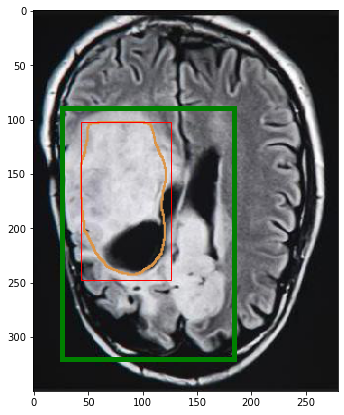

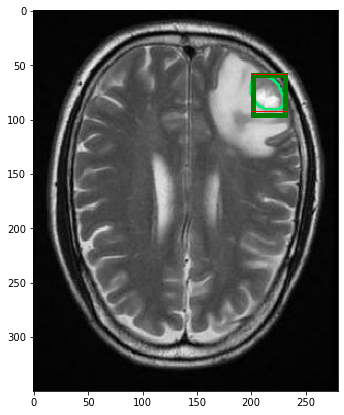

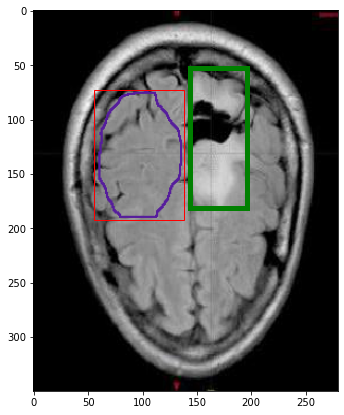

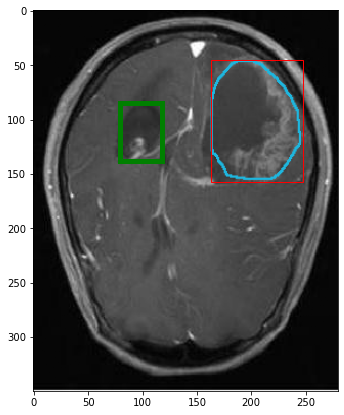

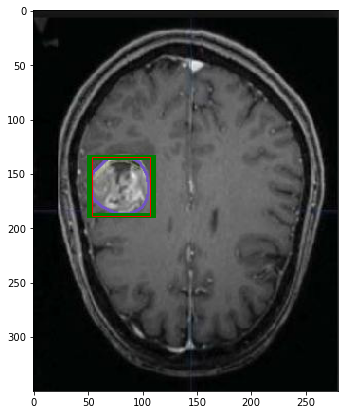

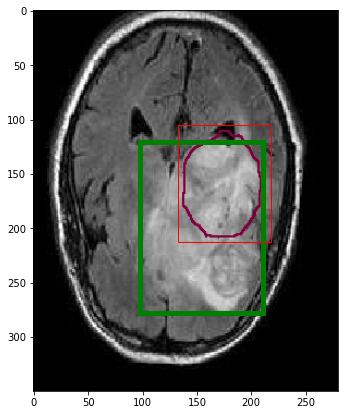

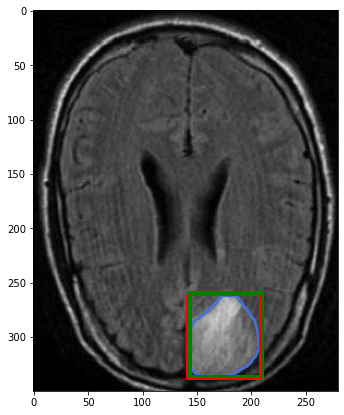

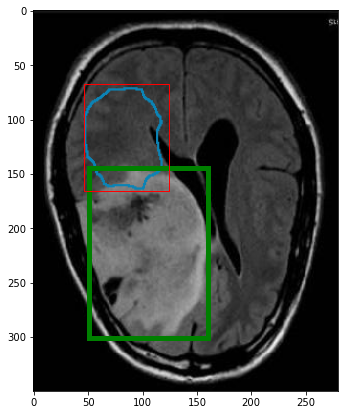

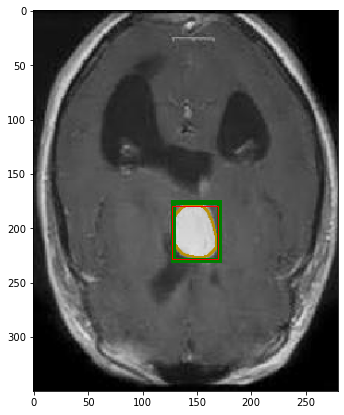

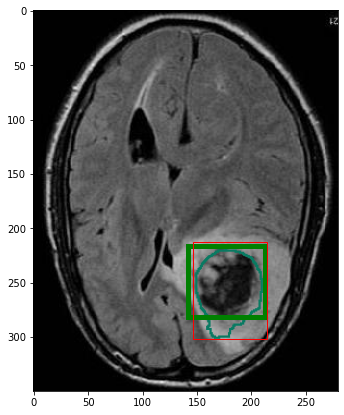

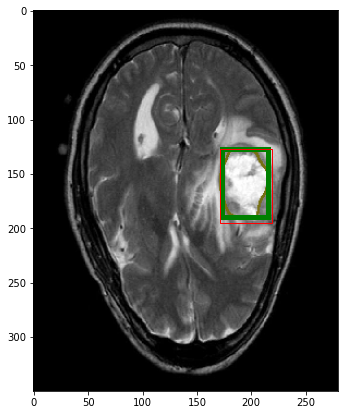

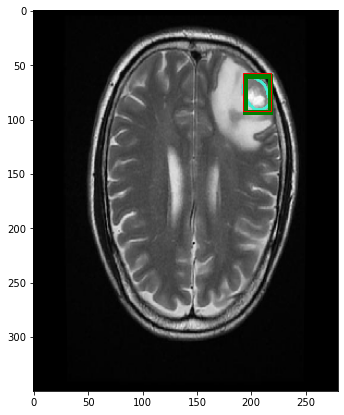

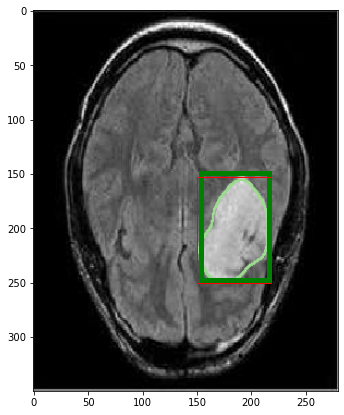

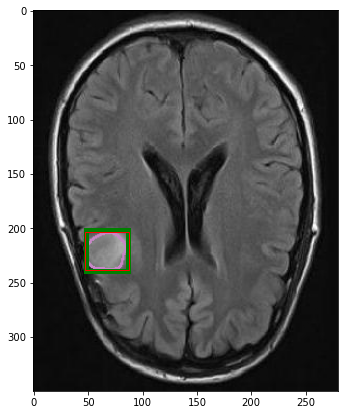

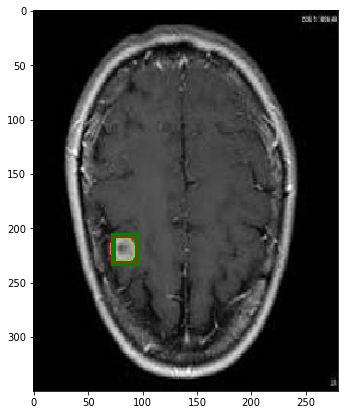

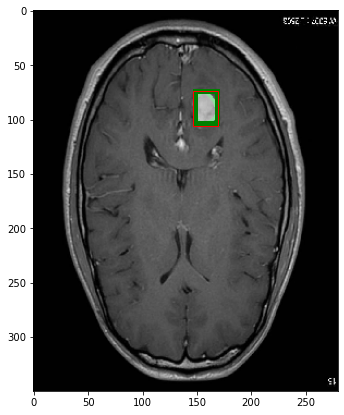

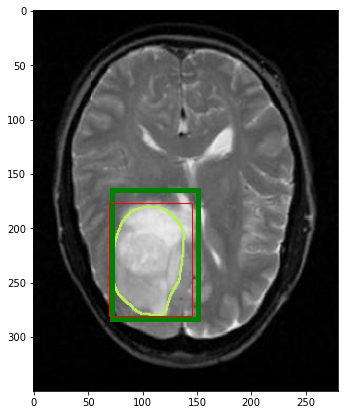

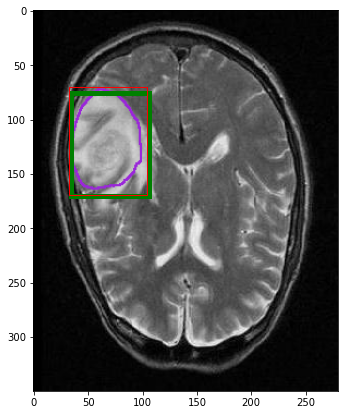

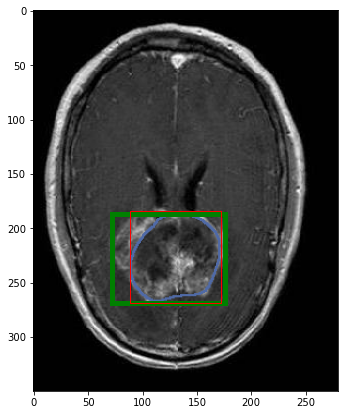

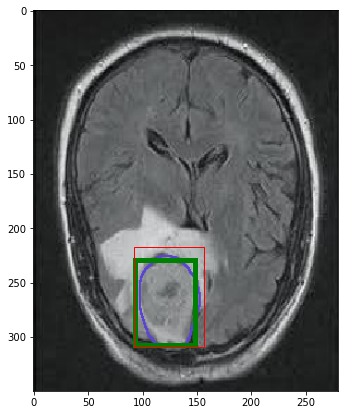

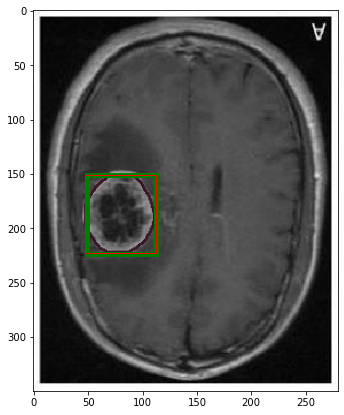

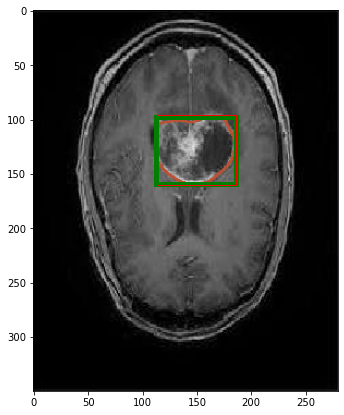

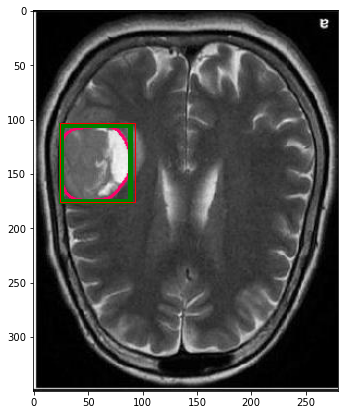

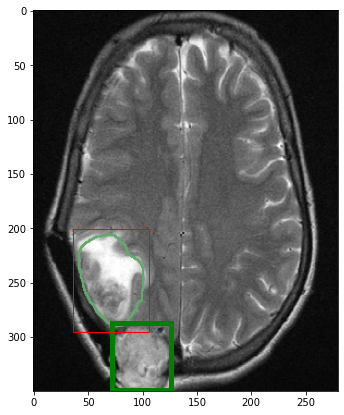

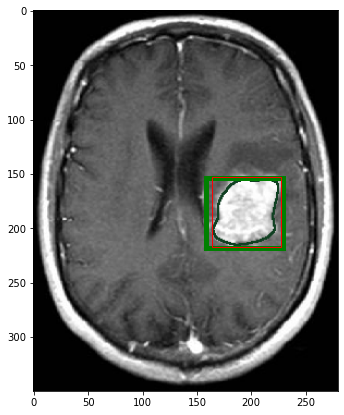

In [57]:
# FIXME remove this and make paste_masks_in_image run on the GPU
torch.set_num_threads(1)
cpu_device = torch.device("cpu")
for images,targets in test_dataloader:
#images, targets =next(next(iter(test_dataloader)))

    images = list(img.to(cpu_device) for img in images)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    model.eval()
    model=model.to(cpu_device)
    outputs = model(images)

    targets2 = [{}] * len(images)
    for j in range(len(targets2)):
        for j2, v2 in targets.items():
            targets2[j][j2] = v2[j].to(cpu_device)

    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    #print(images)

    imid=3
    timg=images[imid][:,:,:].numpy()
    #timg=images[0].detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(10,7))
    #add rectangle to plot

    ax.imshow(np.moveaxis(timg,0,-1))
    ax.add_patch(plt.Rectangle((targets['boxes'][imid][0][0], targets['boxes'][imid][0][1]),  targets['boxes'][imid][0][2]- targets['boxes'][imid][0][0], targets['boxes'][imid][0][3]- targets['boxes'][imid][0][1],fill=False,edgecolor = 'green',lw=5))
    #plt.show()
    imt2=np.moveaxis(timg,0,-1).copy()

    for i in range(1):
        ax.add_patch(plt.Rectangle((outputs[imid]['boxes'][i][0].item(),outputs[imid]['boxes'][i][1].item()),outputs[imid]['boxes'][i][2].item()-outputs[imid]['boxes'][i][0].item() ,outputs[imid]['boxes'][i][3].item()-outputs[imid]['boxes'][i][1].item() ,fill=False,edgecolor = 'red' )  )
        bw_on_image(imt2,(find_edge( np.squeeze(np.moveaxis(outputs[imid]['masks'][i].detach().numpy(),0,-1))>0.5)),[np.random.rand(),np.random.rand(),np.random.rand()])
    ax.imshow(imt2)
    plt.show()

In [164]:

print((np.squeeze(np.moveaxis(outputs[0]['masks'][0].detach().numpy(),0,-1))))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00784309 0.01089884 0.01395458 ... 0.01500163 0.01271713 0.01043259]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [49]:
print((images[0][:,:,:].shape))

torch.Size([3, 350, 280])
